# Implementing Kernel for Face Detection and Recognition

## import all neccessary library

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import argparse
import facenet
import detect_face
import os
from os.path import join as pjoin
import sys
import time
import copy
import math
import pickle
from sklearn.svm import SVC
from sklearn.externals import joblib



## Load up face detection 

In [4]:
print('Creating networks and loading parameters')
with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_mtcnn(sess, '../facenet/src/align/')

        minsize = 20  # minimum size of face
        threshold = [0.6, 0.7, 0.7]  # three steps's threshold
        factor = 0.709  # scale factor
        margin = 44
        frame_interval = 3
        batch_size = 1000
        image_size = 182
        input_image_size = 160

        HumanNames = ['Deemarc','MintRoamAlone','KaewBNK48','UNKNOWN','UNKNOWN']    #train human name

        print('Loading feature extraction model')
        modeldir = './modelSaved/20170511-185253/20170511-185253.pb'
        facenet.load_model(modeldir)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        embedding_size = embeddings.get_shape()[1]

        classifier_filename = './class/my_classifier.pkl'
        classifier_filename_exp = os.path.expanduser(classifier_filename)
        with open(classifier_filename_exp, 'rb') as infile:
            (model, class_names) = pickle.load(infile)
            print('load classifier file-> %s' % classifier_filename_exp)

Creating networks and loading parameters
Loading feature extraction model
Model filename: ./modelSaved/20170511-185253/20170511-185253.pb
load classifier file-> ./class/my_classifier.pkl


In [18]:
print(embedding_size)

128


## Read in Image

This image is: <class 'numpy.ndarray'> with dimensions: (637, 1133, 3)


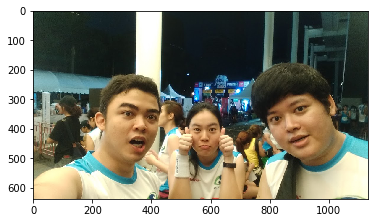

In [5]:
%matplotlib inline
imageTry = mpimg.imread('input/deemarc/deemarc_test.jpg')
#printing out some stats and plotting
print('This image is:', type(imageTry), 'with dimensions:', imageTry.shape)
plt.imshow(imageTry)

In [6]:
bounding_boxes, _ = detect_face.detect_face(imageTry, minsize, pnet, rnet, onet, threshold, factor)
nrof_faces = bounding_boxes.shape[0]
print('Detected_FaceNum: %d' % nrof_faces)
nrof_successfully_aligned = 0
print(bounding_boxes)

Detected_FaceNum: 3
[[  2.37214204e+02   2.56308469e+02   4.27439333e+02   5.07728782e+02
    9.99999881e-01]
 [  5.28878799e+02   3.43757406e+02   6.36583520e+02   4.93068559e+02
    9.99971747e-01]
 [  7.88594773e+02   2.70777258e+02   1.00077772e+03   5.06102250e+02
    9.99905586e-01]]


In [7]:
det = bounding_boxes[:, 0:4]
print(bounding_boxes[:, 0:4])

[[  237.21420443   256.30846941   427.4393332    507.72878158]
 [  528.87879854   343.7574058    636.58352035   493.06855881]
 [  788.59477343   270.77725781  1000.77771544   506.10224961]]


In [8]:
img_size = np.asarray(imageTry.shape)[0:2]
bounding_box_size = (det[:, 2] - det[:, 0]) * (det[:, 3] - det[:, 1])
print(bounding_box_size)

[ 47826.46125718  16081.51619779  49931.94908908]


In [9]:
img_center = img_size / 2
offsets = np.vstack([(det[:, 0] + det[:, 2]) / 2 - img_center[1],
                     (det[:, 1] + det[:, 3]) / 2 - img_center[0]])
print(offsets)

[[-234.17323118   16.23115945  328.18624444]
 [  63.5186255    99.91298231   69.93975371]]


In [10]:
offset_dist_squared = np.sum(np.power(offsets, 2.0), 0)
print(offset_dist_squared)

[  58871.71798851   10246.0545706   112597.78018851]


In [11]:
det = np.squeeze(det)
print(det)

[[  237.21420443   256.30846941   427.4393332    507.72878158]
 [  528.87879854   343.7574058    636.58352035   493.06855881]
 [  788.59477343   270.77725781  1000.77771544   506.10224961]]


In [44]:
bb_temp = np.zeros(4, dtype=np.int32)
print(bb_temp)

[0 0 0 0]


[237 256 427 507]
[528 343 636 493]
[ 788  270 1000  506]


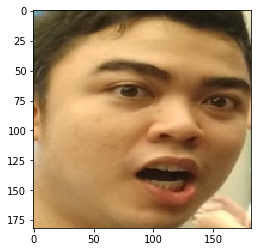

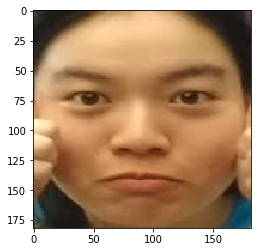

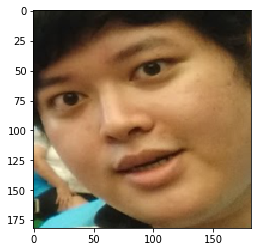

In [50]:
for face in det:
    bb_temp[0] = face[0]
    bb_temp[1] = face[1]
    bb_temp[2] = face[2]
    bb_temp[3] = face[3]
    print(bb_temp)
    cropped_temp = imageTry[bb_temp[1]:bb_temp[3], bb_temp[0]:bb_temp[2], :]
    scaled_temp = misc.imresize(cropped_temp, (image_size, image_size), interp='bilinear')
#     scaled_temp = misc.imresize(cropped_temp, (image_size, image_size), interp='bilinear')
    plt.figure()
    plt.imshow(scaled_temp)

In [37]:
print(cropped_temp)

[[[ 43  43  33]
  [ 40  40  30]
  [ 41  41  31]
  ..., 
  [ 25  26  21]
  [ 22  23  18]
  [ 23  24  19]]

 [[ 42  42  32]
  [ 38  38  28]
  [ 39  39  29]
  ..., 
  [ 25  26  21]
  [ 21  22  17]
  [ 23  24  19]]

 [[ 42  43  35]
  [ 42  43  35]
  [ 44  45  37]
  ..., 
  [ 20  26  14]
  [ 21  27  15]
  [ 19  25  15]]

 ..., 
 [[ 32 101  36]
  [ 42 111  46]
  [ 46 116  54]
  ..., 
  [130 110  59]
  [135 112  62]
  [141 113  65]]

 [[ 25  96  30]
  [ 25  99  36]
  [ 34 112  54]
  ..., 
  [129 107  57]
  [129 106  54]
  [135 107  57]]

 [[ 21  95  32]
  [ 27 107  46]
  [ 19 104  49]
  ..., 
  [138 111  64]
  [134 106  58]
  [144 113  67]]]


In [38]:
print(bb_temp)

[ 788  270 1000  506]
